# Evaluation Metrics for Classification
In the previous seesion, we trained a model for predicting churn. How do we know if it's good?

## [Evaluation metrics - session overview](https://www.youtube.com/watch?v=gmg5jw1bM8A&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=42)
- [Dataset](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv)

*Metric*. - function that compares the predictions with the actual values and outputs a single number that tells how good the predicitons are

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Data Import and Preparation

In [10]:
csv_url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(csv_url)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [11]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [13]:
categorical_columns

['customerid',
 'gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'totalcharges',
 'churn']

In [15]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
     'gender',
     'seniorcitizen',
     'partner',
     'dependents',
     'phoneservice',
     'multiplelines',
     'internetservice',
     'onlinesecurity',
     'onlinebackup',
     'deviceprotection',
     'techsupport',
     'streamingtv',
     'streamingmovies',
     'contract',
     'paperlessbilling',
     'paymentmethod',
              ]

In [16]:
dv = DictVectorizer(sparse = False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [18]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## [Accuracy and Dummy Model](https://www.youtube.com/watch?v=FW_l7lB0HUI&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=43)
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

**Accuracy** = tells us about the fraction of correct predictions

In [19]:
len(y_val)

1409

In [20]:
(y_val == churn_decision).sum()

1132

In [21]:
accuracy = (y_val == churn_decision).sum() / len(y_val); accuracy

0.8034066713981547

But is using the 50% threshold good enough?

In [25]:
thresholds = np.linspace(0,1,21)

scores = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)


0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


It looks like 0.5 has the highest accuracy (accuracy score 0.803)

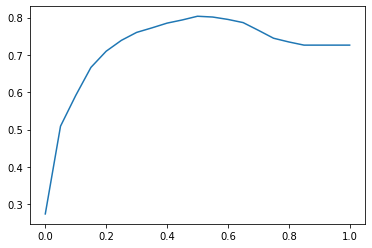

In [26]:
plt.plot(thresholds, scores)

### Sklearn Accuracy Implementation

In [28]:
# let's implement sklearn's accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [29]:
thresholds = np.linspace(0,1,21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)


0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


What this means is that we assume that no customer is going to churn, the accuracy of our model is 72.6%. Why do we bother with making a more complex model, and get model accuracy of 80%?

Out data has a **class imbalance** - 1/3 of the data is churning while the rest is not churning. **Accuracy** would **not be the best evaluation metric** to use for such case scenario.

## Confusion Table = True and False Positives and True and False Negatives
- Different types of errors and correct decisions
- Arranging them in a table

In [32]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [33]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [42]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [43]:
tp, tn, fp, fn

(210, 922, 101, 176)

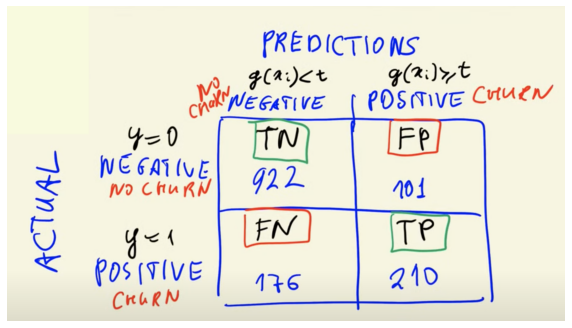

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('confusion_matrix.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [45]:
confusion_matrix = np.array([
    [tn,fp],
    [fn,tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

**Conclusion**: As a result, false negatives are more of a grave error cause those are the customers who will churn, and they will not get the discount, whereas the false positive get the promotional email and they were not going to churn. In both cases, we are losing profit.
<br>**Accuracy** = 65% of true negatives and 15% of true negatives.

## Precision and Recall

accuracy = (tp + tn)/(tp + tn + fp + fn)
<br>precisison = fraction of positive predictions that are correct
<br>precision = tp / (tp + fp)
<br>recall = fraction of correctly identified positve examples
<br>recall = tp / (tp + fn)

In [47]:
# about 33% of people got an email by mistake (fp = 101 and tp = 210)
precision = tp / (tp + fp); precision

0.6752411575562701

In [53]:
# in abput 46% of the people who are churning, we will fail to identify them 
recall = tp / (tp + fn); recall

0.5440414507772021

In [55]:
# but at first look, the model performance looks good from the accuracy standpoint
accuracy

0.8034066713981547

## [ROC Curves](https://www.youtube.com/watch?v=dnBZLk53sQI&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=46) = Receiver Operating Characteristic

This comes from the WWII to evaluate the strength of a radar: receiver wants to know if the plane is flying over the radar or not.

### TPR and FPR = True Positive Rate and False Positive Rate

- TPR = True positives / all positives =  TP / (TP + FN) = **Same as recall**
- FPR = False positives / all negatives = FP / (TN + FP)

In [56]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

In [58]:
tpr, fpr

(0.5440414507772021, 0.09872922776148582)

Let's evaluate the tpr and fpr for all possible thresholds

In [59]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))


In [64]:
df_scores = pd.DataFrame(scores, columns = ['threshold', 'tp', 'fp', 'fn', 'tn'])

In [66]:
# move with increments of 10
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [67]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

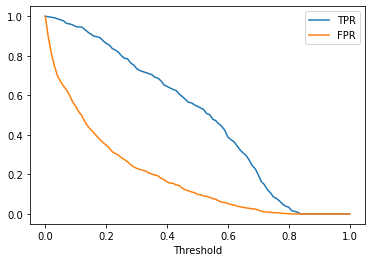

In [73]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.xlabel('Threshold')
plt.legend()

**Goal**: Our goal is to minimize FPR and maximize TPR

### Random Model

In [74]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size = len(y_val))

In [76]:
# model accuracy
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [78]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
    
    df_scores = pd.DataFrame(scores, columns = ['threshold', 'tp', 'fp', 'fn', 'tn'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores 

In [79]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [81]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


In [103]:
def tpr_fpr_plot(df, color_tpr = 'blue', color_fpr = 'orange'):
    plt.plot(df.threshold, df['tpr'], label = 'TPR', color = color_tpr)
    plt.plot(df.threshold, df['fpr'], label = 'FPR', color = color_fpr)
    plt.xlabel('Threshold')
    plt.legend()

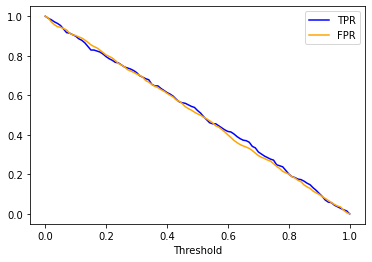

In [104]:
tpr_fpr_plot(df_rand)

This model is similar to throwing a coin. At a threshold value of 0.6, we predict that in 60% of the cases, this customer is not churning and 40% of the customers are churning.

### Ideal Model

But what do we actually want to achieve with our model? We order the predictions from the smallest to the largest scores. If threshold is 72%, 72% of our customers did not churn and the remaining 28% of the customers churned.

In [87]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

In [88]:
num_neg, num_pos

(1023, 386)

In [94]:
y_ideal = np.repeat([0,1], [num_neg, num_pos]); y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [95]:
y_ideal_predictions = np.linspace(0,1, len(y_val))

In [98]:
1 - y_val.mean()

0.7260468417317246

In [99]:
# Accuracy
((y_ideal_predictions >=0.726) == y_ideal).mean()

1.0

This model does not exist in reality, but oh well

In [100]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_predictions)

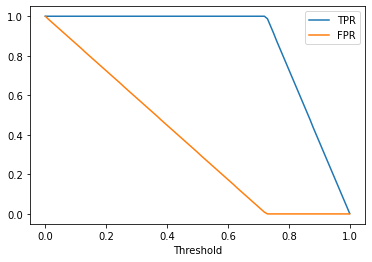

In [101]:
tpr_fpr_plot(df_ideal)

### Putting everything together

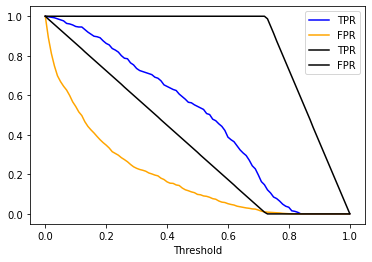

In [105]:
tpr_fpr_plot(df_scores)
#tpr_fpr_plot(df_rand)
tpr_fpr_plot(df_ideal, color_tpr = 'black', color_fpr = 'black')

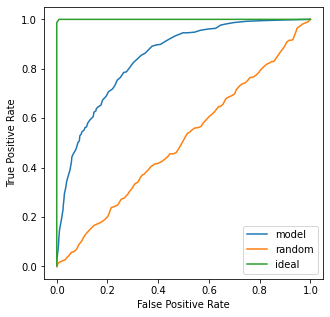

In [108]:
plt.figure(figsize = (5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot(df_rand.fpr, df_rand.tpr, label = 'random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

We want the model curve to be as close as close as possible to the top left corner

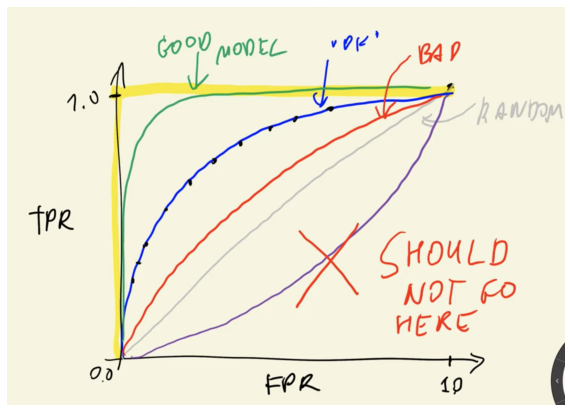

In [109]:
from PIL import Image
import matplotlib.pyplot as plt
img1 = Image.open('model_comparisons.png')
plt.figure(figsize=(10, 8))
plt.imshow(img1)
plt.axis('off')
plt.show()

### ROC Curve with Sklean

In [110]:
from sklearn.metrics import roc_curve

In [111]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

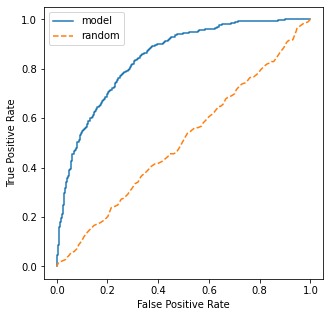

In [113]:
plt.figure(figsize = (5,5))

plt.plot(fpr, tpr, label = 'model')
plt.plot(df_rand.fpr, df_rand.tpr, label = 'random', linestyle ='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## [ROC AUC](https://www.youtube.com/watch?v=hvIQPAwkVZo&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=48)
- Area under the ROC curve - useful metric
- Interpretation of AUC

Our model will have AUC between 0.5 (random curve) and 1 (ideal model)

In [114]:
from sklearn.metrics import auc

In [115]:
auc(fpr, tpr)

0.843850505725819

In [120]:
#manual model evaluation
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [117]:
#manual model evaluation of the ideal model
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [122]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.843850505725819

In [118]:
from sklearn.metrics import roc_auc_score

In [121]:
roc_auc_score(y_val, y_pred)

0.843850505725819

# *NOT FINISHED*

## [Cross-Validation](https://www.youtube.com/watch?v=BIIZaVtUbf4&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=49)
- Evaluating the same model on different subsets of data
- Getting the average prediciton and the spread withing predictions

## [Summary](https://www.youtube.com/watch?v=-v8XEQ2AHvQ&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=50)